In [61]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

# File Collection

In [269]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        # CHANGEME below is for site A2
        if file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site A2
        #if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site C1A
        #if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]


In [277]:
# Usage for BLOC
BLOC_start_date = '20231201'  # Replace with any start date
BLOC_end_date = '20250124'    # Replace with any end date
BLOC_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
BLOC_files = filter_files_by_date(BLOC_directory, BLOC_start_date, BLOC_end_date)

# Usage for Site C1a
C1A_start_date = '20221111'  # Replace with any start date
C1A_end_date = '20231106'    # Replace with any end date
C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'
C1A_files = filter_files_by_date(C1A_directory, C1A_start_date, C1A_end_date)


# Wind Veer Function

In [227]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    return diff
    
def calculate_wind_veer(file_paths):
    """
    Calculate wind veer and wind shear from netCDF files, using Azim for wind direction and qc_Azim for quality control.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
    
    Returns:
        tuple: Times (datetime objects), wind veer values, and wind shear values.
    """
    all_times = []
    all_wind_veer = []

    for file_path in file_paths:
        ds = xr.open_dataset(file_path)
        
        # Extract data
        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values
        azim = ds['Azim'].values
        qc_azim = ds['qc_Azim'].values
        
        times = pd.to_datetime(time_var.values, utc=True)

        # Ensure height indices for 40m and 140m are correct
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            print(f"Height levels not found in {height_var}")
            continue
        
        # Calculate wind veer
        wind_direction_40m = azim[:, idx_40m]
        wind_direction_140m = azim[:, idx_140m]

        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        wind_veer = difference / (height_var[idx_140m] - height_var[idx_40m])

        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]

        # Append data
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)

    return all_times, all_wind_veer


# Wind Shear using Power Law

In [72]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)

def calculate_wind_shear_with_alpha(file_paths, start_date=None, end_date=None):
    all_times = []
    all_alpha = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)

        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values
        
        #print(f"Height variable: {height_var}")
        #print(f"Vhm shape: {vhm.shape}, QC shape: {qc_vhm.shape}")

        times = pd.to_datetime(time_var.values, utc=True)
        
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            #print(f"Valid time indices: {np.sum(valid_idx)}")
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
        
        idx_40m = np.where(height_var == 40)[0]
        idx_140m = np.where(height_var == 140)[0]
        
        if len(idx_40m) == 0 or len(idx_140m) == 0:
            print(f"Available heights: {height_var}")
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        idx_40m, idx_140m = idx_40m[0], idx_140m[0]
        #print(f"Indices for 40m: {idx_40m}, 140m: {idx_140m}")

        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]
        
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0)
        #print(f"Valid mask has {np.sum(valid_mask)} valid entries")
        
        times = times[valid_mask]
        wind_speed_40m = wind_speed_40m[valid_mask]
        wind_speed_140m = wind_speed_140m[valid_mask]

        if len(times) == 0:
            #print("on file: ", file_path)
            #print("No valid data points after filtering by QC.")
            continue
        
        try:
            alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
        except ValueError as e:
            print(f"Error in alpha calculation: {e}")
            continue

        #print(f"Calculated alpha values: {alpha[:5]} (showing first 5)")
        all_times.extend(times)
        all_alpha.extend(alpha)

    return all_times, all_alpha


In [74]:
# Storing BLOC Wind Veer and Wind Shear
BLOC_start_date = datetime(2023, 12, 1)
BLOC_end_date = datetime(2025, 1, 24)
BLOC_times_veer, BLOC_wind_veer = calculate_wind_veer(BLOC_files, start_date=BLOC_start_date, end_date=BLOC_end_date)
BLOC_times_shear, BLOC_wind_shear = calculate_wind_shear_with_alpha(BLOC_files, start_date=BLOC_start_date, end_date=BLOC_end_date)

# Storing C1A Wind Veer and Wind Shear
C1A_start_date = datetime(2022, 11, 11)
C1A_end_date = datetime(2023, 11, 6)
C1A_times_veer, C1A_wind_veer = calculate_wind_veer(C1A_files, start_date=C1A_start_date, end_date=C1A_end_date)
C1A_times_shear, C1A_wind_shear = calculate_wind_shear_with_alpha(C1A_files, start_date=C1A_start_date, end_date=C1A_end_date)


# Daily Average - Wind Veer Overlay

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotDailyAvgWindVeer(times, wind_veer, start_date, end_date):
    """
    Plots daily average wind veer averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times and wind_veer match
    if not len(times) == len(wind_veer):
        raise ValueError("The lengths of 'times' and 'wind_veer' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages and standard deviations (for error bars)
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
    daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)

    # Find the time and value of max veer
    max_veer_value = daily_avg_veer.max()
    max_veer_time = daily_avg_veer.idxmax()

    print(f"Maximum Wind Veer: {max_veer_value} deg/m at {max_veer_time}")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Wind Veer with error bars (blue)
    ax1.errorbar(
        daily_avg_veer.index, daily_avg_veer.values, 
        yerr=daily_std_veer.values, fmt='o', color='blue', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='blue', linestyle='--', label='Wind Veer (deg/m)', zorder=1
    )
    
    # Add marker for Max Veer (purple)
    ax1.scatter(max_veer_time, max_veer_value, color='purple', zorder=2, 
                label='Max Veer')

    # Add vertical line for max veer (on top, highest zorder)
    ax1.axvline(x=max_veer_time, color='purple', linestyle='--', label='_nolegend_', zorder=3)

    # Update to use correct xticks and xticklabels
    ax1.set_xticks(np.arange(len(all_times)))  # This should already give you 24 ticks
    ax1.set_xticklabels(all_times, rotation=45)
    
    ax1.set_xlabel('Time of Day (UTC)')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # CHANGEME Title for Site A2
    #ax1.set_title(f'Site A2 Daily Average Wind Veer from {start_date.date()} to {end_date.date()}')

    # CHANGEME Title for Site BLOC
    ax1.set_title(f'Site BLOC Daily Average Wind Veer from {start_date.date()} to {end_date.date()}\n'
                 f'Hub Height: 40 m to 140 m')


    # Create a proxy artist for Max Veer point (to avoid float handles)
    max_veer_proxy = Line2D([0], [0], marker='o', color='purple', linestyle='None', markersize=8)

    # Add legend for the line (Veer) and Max marker only
    ax1.legend([veer_line], ['Wind Veer'], loc='upper left')

    # Add legend for max point (using proxy artist)
    ax1.legend(handles=[max_veer_proxy], labels=['Max Veer'], loc='upper right')

    plt.tight_layout()
    plt.show()


In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def getDailyAvgWindVeer(times, wind_veer, start_date, end_date):
    """
    Returns the daily average wind veer and corresponding times, averaged across all days at each time of day.
    The result is a DataFrame with time of day and the corresponding average wind veer.
    """
    # Check if the lengths of times and wind_veer match
    if not len(times) == len(wind_veer):
        raise ValueError("The lengths of 'times' and 'wind_veer' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')
  
    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer
    })
    
    print(f"Unfiltered DataFrame:\n{df.head()}")
    # Filtering between start and end date
    #df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    
    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)

    # Print the daily_avg_veer to check if values are being calculated correctly
    print(f"Daily Average Wind Veer (BLOC):\n{daily_avg_veer.head()}")

    # Return a DataFrame containing the time of day and the corresponding daily average veer
    return pd.DataFrame({
        'time_of_day': daily_avg_veer.index,
        'average_wind_veer': daily_avg_veer.values
    })

# Plotting function to plot multiple dataframes
def plotMultipleDataFrames(dataframes, labels=None, title="Multiple DataFrame Plot", xlabel="Time of Day", ylabel="Average Wind Veer (deg/m)"):
    """
    Plots multiple dataframes on the same plot.
    Each dataframe should contain 'time_of_day' and 'average_wind_veer' columns.
    """
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Loop through each dataframe and plot it
    for idx, df in enumerate(dataframes):
        # Check that 'time_of_day' and 'average_wind_veer' columns exist
        if 'time_of_day' not in df or 'average_wind_veer' not in df:
            print(f"DataFrame {idx} is missing required columns.")
            continue

        # If labels are provided, use them, otherwise use the index
        label = labels[idx] if labels is not None else f"Dataset {idx+1}"

        # Print a few rows to debug
        print(f"Plotting {label}:\n{df.head()}")

        # Plot the data
        ax.plot(df['time_of_day'], df['average_wind_veer'], label=label, marker='o')

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)

    # Add a legend
    ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()


['/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221101.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221101.223400.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221102.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221103.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221104.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221105.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221106.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221107.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A/sc1.lidar.z03.c0.20221108.000200.sta.nc', '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A

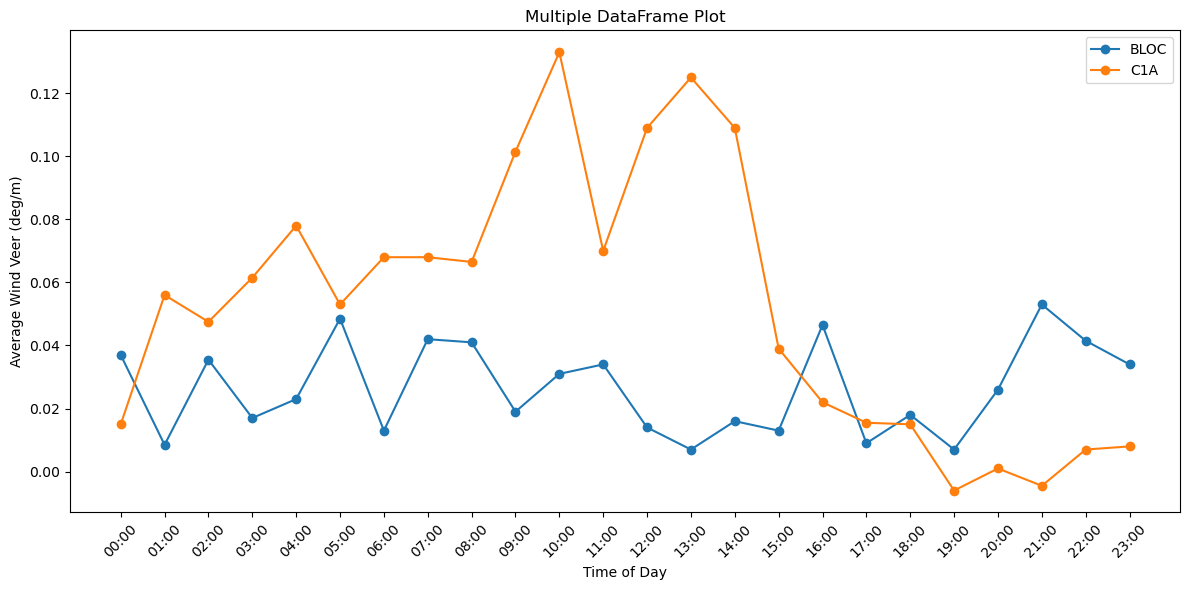

In [283]:

# Example usage:
# Assuming you have the times and wind_veer data available for BLOC and C1A
# Assuming calculate_wind_veer is implemented and gives the required times and veer values

# Usage for BLOC
BLOC_start_date = '20231201'  # Replace with any start date
BLOC_end_date = '20231228'    # Replace with any end date
BLOC_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
BLOC_files = filter_files_by_date(BLOC_directory, BLOC_start_date, BLOC_end_date)

# Usage for Site C1a
C1A_start_date = '20221101'  # Replace with any start date
C1A_end_date = '20221130'    # Replace with any end date
C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'
C1A_files = filter_files_by_date(C1A_directory, C1A_start_date, C1A_end_date)
print(C1A_files)

# Storing BLOC Wind Veer and Wind Shear
BLOC_DJF_start = pd.to_datetime('2023-12-01')
BLOC_DJF_end = pd.to_datetime('2023-12-28')
BLOC_times_veer, BLOC_wind_veer = calculate_wind_veer(BLOC_files)
BLOC_daily_veer = getDailyAvgWindVeer(BLOC_times_veer, BLOC_wind_veer, BLOC_DJF_start, BLOC_DJF_end)

# Storing C1A Wind Veer and Wind Shear
C1A_DJF_start = pd.to_datetime('2022-12-01')
C1A_DJF_end = pd.to_datetime('2022-02-28')
C1A_times_veer, C1A_wind_veer = calculate_wind_veer(C1A_files)
C1A_daily_veer = getDailyAvgWindVeer(C1A_times_veer, C1A_wind_veer, C1A_DJF_start, C1A_DJF_end)

# Now plot multiple dataframes
plotMultipleDataFrames([BLOC_daily_veer, C1A_daily_veer], labels=["BLOC", "C1A"])